# Ellipsoid Lightcurves with Error

This notebook is used for viewing the light curves of stars that have crossed the SETI Ellipsoid for SN1054 during Gaia DR3 observation time period, including the error in crossing time

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import constants as const
from astropy import units as u
from astropy.time import Time
from astropy.table import Table, QTable, vstack
import os

from astroquery.gaia import Gaia

import sys
sys.path.append('..')
import ellipsoid

from astropy.timeseries import LombScargle, TimeSeries
import random

### Read in the desired file and set global parameters
If using the ```ellipsoid.py``` script to download Gaia data, the file names are:

```GCNS_var``` -- variable stars in GCNS

```Gaia_var``` -- variable stars in Gaia DR3

```GCNS``` -- stars in GCNS

```Gaia``` -- stars in Gaia DR3

The tolerance is in lightyears, and the default start time is the time of the first Gaia alert

In [3]:
file_name = '../Gaia_var_class'
c1, stars = ellipsoid.readFile(file_name)
tol = 0.1

The default event (i.e. the second focal point of the SETI Ellipsoid) is SN1054 for this notebook, and its parameters are set below

In [4]:
# Properties of SN1054 (Crab Nebula)
t0 = Time({'year': 1054, 'month': 7, 'day': 4}, format='ymdhms')

c0_radec = SkyCoord.from_name('SN 1054')

# https://vizier.cds.unistra.fr/viz-bin/VizieR-4 database (photogeometric distance)
d0 = 1899.33655000 * u.pc
d0_err = (2193.16919000-1711.93213000)/2 * u.pc

c0 = SkyCoord(ra=c0_radec.ra, dec=c0_radec.dec, distance=d0)

/mnt_home/anilipour/setiellipsoid/setienv/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  ErfaWarning)


In [5]:
len(c1)

9322432

### Get table of crossing stars

```c1_x``` contains astropy SkyCoord objects of each star that has crossed (within some tolerance) the ellipsoid since the start time

```stars_x``` is a table with all the relevant information for each of the stars

In [8]:
c1_x2, stars_x2 = ellipsoid.crossEllipsoid(c0, t0, c1, stars, tol, start=Time('2014-07-25T10:30', format='isot'), end=Time('2017-05-28T08:44', format='isot'))
print(f'{len(stars_x2)} stars have crossed the ellipsoid during Gaia DR3 data collection time (excluding error)')

1810 stars have crossed the ellipsoid during Gaia DR3 data collection time (excluding error)


In [7]:
c1_x, stars_x = ellipsoid.crossErrorEllipsoid(c0, t0, c1, stars, tol)
print(f'{len(stars_x)} stars have crossed the ellipsoid during Gaia DR3 data collection time')

8 stars have crossed the ellipsoid during Gaia DR3 data collection time


### Login to Gaia archive

Creating and logging into a Gaia archive account allows for larger data downloads

You can register here:
https://www.cosmos.esa.int/web/gaia-users/register

In [ ]:
Gaia.login()

### Split the desired stars into chunks of =< 5000 (if needed)

Datalink, the protocol Gaia uses for ancillary data such as epoch photometry and spectra, can only retrieve data for up to 5000 sources at a time. This threshold is overcome by splitting the input into chunks of size =< 5000 sources.

In [12]:
def chunks(lst, n):
    ""
    "Split an input list into multiple chunks of size =< n"
    ""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [13]:
dl_threshold = 5000               # DataLink server threshold. It is not possible to download products for more than 5000 sources in one single call.
ids          = stars_x['id']
ids_chunks   = list(chunks(ids, dl_threshold))
datalink_all = []


print(f'* Input list contains {len(ids)} source_IDs')
print(f'* This list is split into {len(ids_chunks)} chunks of <= {dl_threshold} elements each')

* Input list contains 8 source_IDs
* This list is split into 1 chunks of <= 5000 elements each


### Get lightcurves

When downloading, light curves will all be in one table (merged).

Can also save and read light curve tables once downloaded.

In [14]:
retrieval_type = 'EPOCH_PHOTOMETRY'        # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS' 
data_structure = 'COMBINED'   # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW' - but as explained above, we strongly recommend to use COMBINED for massive downloads.
data_release   = 'Gaia DR3'   # Options are: 'Gaia DR3' (default), 'Gaia DR2'
dl_key         = f'{retrieval_type}_{data_structure}.xml'


ii = 0
for chunk in ids_chunks:
    ii = ii + 1
    print(f'Downloading Chunk #{ii}; N_files = {len(chunk)}')
    datalink  = Gaia.load_data(ids=chunk, data_release = data_release, retrieval_type=retrieval_type, format = 'votable', data_structure = data_structure)
    datalink_all.append(datalink)

In [15]:
temp = [inp[dl_key][0].to_table() for inp in datalink_all]
merged = vstack(temp)

Save downloaded table

In [16]:
merged_sf = '../GCNS_var_lc.xml'

if os.path.exists(merged_sf):
    os.remove(merged_sf)    
QTable(merged).write(merged_sf, format='votable')

Read saved table

In [17]:
lc_merged = QTable.read(merged_sf, format='votable')

### Make dictionaries for each band

Each source is observed in three bands by Gaia (G, RP, BP), so here we create a dictionary for each band, with the keys equal to the source IDs and the values equal to the light curve table for that source and band

In [18]:
glcDict = {}
bplcDict = {}
rplcDict = {}

In [19]:
for sid in ids:
    glc, bplc, rplc = ellipsoid.getLC(lc_merged, sid, 'G'), ellipsoid.getLC(lc_merged, sid, 'BP'), ellipsoid.getLC(lc_merged, sid, 'RP')
    glcDict[str(sid)], bplcDict[str(sid)], rplcDict[str(sid)] = glc, bplc, rplc

### Pick random light curve(s) and plot

Here, one or many random source IDs are selected, and their light curves are plotted, as well as a vertical line indicating the ellipsoid crossing time.

In [20]:
lcChoice = random.choice(list(glcDict.keys()))

In [22]:
lcChoices = random.sample(list(glcDict.keys()), k=8)

In [23]:
idMask = np.in1d(stars['id'], [int(i) for i in lcChoices])

In [24]:
stars[idMask]['id', 'class']

id,class
int64,bytes30
4158840442172717440,SOLAR_LIKE
1302439147363430272,SOLAR_LIKE
6011392186336443392,YSO
4180052117402761216,SOLAR_LIKE
5829546092853939712,SOLAR_LIKE
1387247743387653632,SOLAR_LIKE
2038598839702672640,SOLAR_LIKE
4607839243856979968,SOLAR_LIKE


The Gaia archive is again queried to get the Gaia variable classification

In [25]:
lcClass = ellipsoid.varClass(lcChoice)
print(f'Source {lcChoice} has variable classification {lcClass[0]}')

INFO: Query finished. [astroquery.utils.tap.core]
Source 6011392186336443392 has variable classification YSO


In [26]:
lcClasses = ellipsoid.varClasses(tuple(lcChoices))
lcClasses

INFO: Query finished. [astroquery.utils.tap.core]


best_class_name,source_id
bytes30,int64
SOLAR_LIKE,1302439147363430272
SOLAR_LIKE,1387247743387653632
SOLAR_LIKE,2038598839702672640
SOLAR_LIKE,4158840442172717440
SOLAR_LIKE,4180052117402761216
SOLAR_LIKE,4607839243856979968
SOLAR_LIKE,5829546092853939712
YSO,6011392186336443392


Pick a desired source ID

In [29]:
lcID = 6011392186336443392
id_mask = stars_x['id'] == lcID

Get the ellipsoid crossing time for the selected star, as well as the light curve information

In [36]:
xtime = ellipsoid.xTime(c1_x[id_mask], c0, t0)[0]

In [37]:
lcDict = glcDict # choose g, bp, or rp light curve

lcTimes = Time(lcDict[str(lcID)]['time'].value + 2455197.5, format='jd')
lcFlux = lcDict[str(lcID)]['flux']
lcFerr = lcDict[str(lcID)]['flux_error']
lcMag = lcDict[str(lcID)]['mag']
# time offset described at https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_photometry/ssec_dm_epoch_photometry.html

#### Plot with crossing time

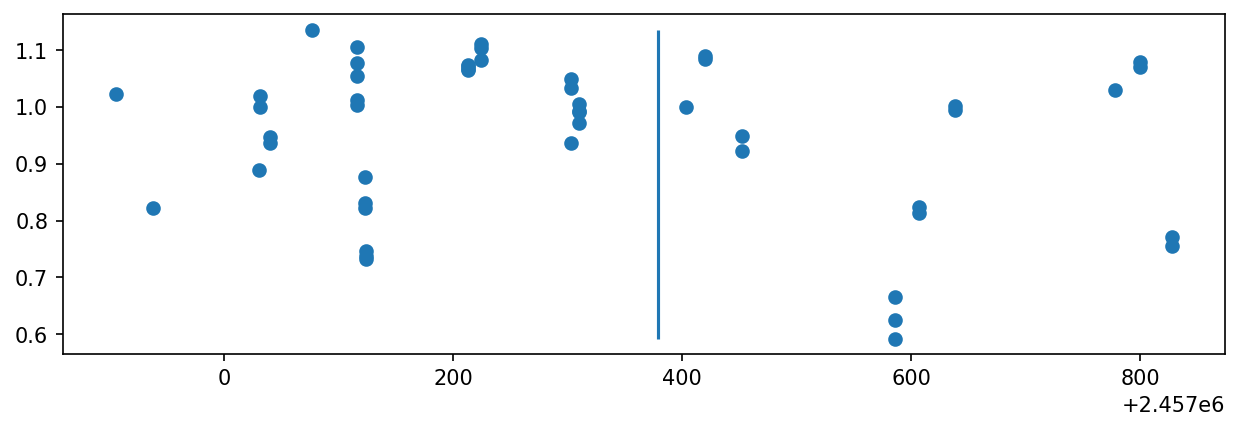

In [38]:
plt.figure(figsize=[10,3], dpi=150)

plt.vlines(xtime, ymin=min(lcFlux.value), ymax=max(lcFlux.value))
plt.scatter(lcTimes.value, lcFlux)

All the above plotting can be done with the ```plotLC``` function:

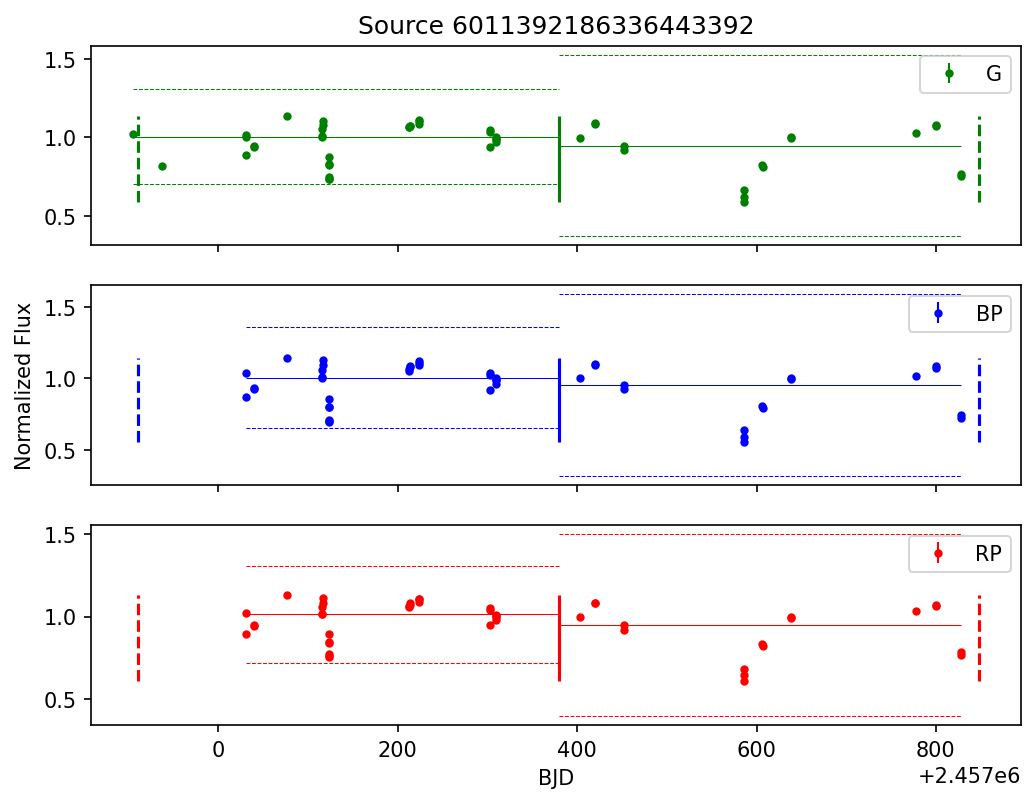

In [43]:
ellipsoid.plotLC(str(lcID), c1_x[id_mask], stars_x[id_mask], glcDict, bplcDict, rplcDict, y='flux', time= ellipsoid.xTime(c1_x[id_mask], c0, t0)[0])

### Plot all light curves and save to folder

In [47]:
for lcID in lcChoices:
    id_mask = stars_x['id'] == int(lcID)

    ellipsoid.plotLC(str(lcID), c1_x[id_mask], stars_x[id_mask], glcDict, bplcDict, rplcDict, y='flux', median=False, time=ellipsoid.xTime(c1_x[id_mask], c0, t0)[0])

    plt.savefig(f'light_curves/{lcID}', transparent=False, facecolor='white')
    plt.close()